<a href="https://colab.research.google.com/github/KutapiAise/DataScience/blob/master/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import datetime
import numpy as np #CORRECTION: was missing, later np. call not working
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix ##CORRECTION: was not imported and called incorrectly later
from math import ceil ##CORRECTION: was not imported and call was not working later
from sklearn import preprocessing ##CORRECTION: was not imported and preprocessing couldn't be called by itself
from sklearn.model_selection import train_test_split ##CORRECTION: was missing and messing up our X_train data later
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



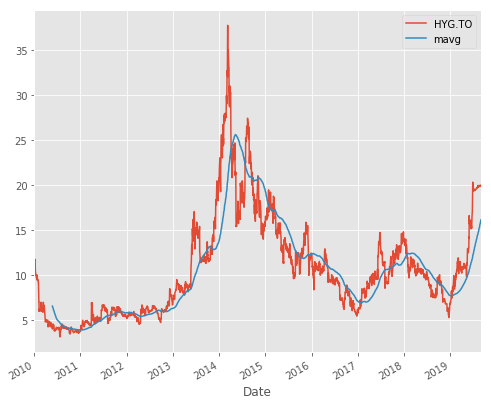

In [0]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("HYG.TO", "yahoo", start, end)
df.tail()

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

#to better understand rolling mean, let's plot it on matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='HYG.TO')
mavg.plot(label='mavg')
plt.legend()



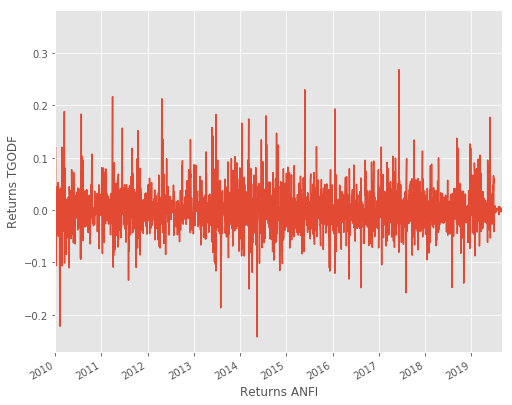

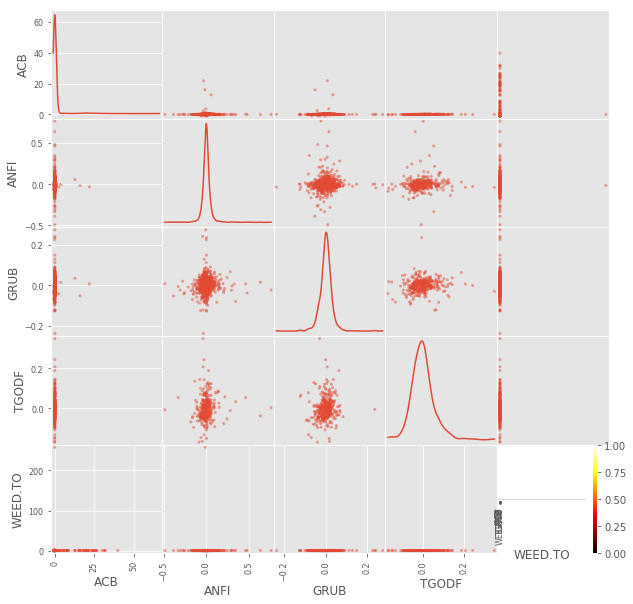

In [0]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

#analyzing competitor stocks as well
dfcomp = web.DataReader(['ANFI', 'TGODF', 'ACB', 'WEED.TO', 'GRUB'], 'yahoo', start=start, end=end)['Adj Close']

# run a correlation function to see if any of the stocks are correlated
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

#plotting competitors to see their return distributions
plt.scatter(retscomp.ANFI, retscomp.TGODF)
plt.xlabel('Returns ANFI')
plt.ylabel('Returns TGODF')

#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

#create a heatmap to prove the positive correlations
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);




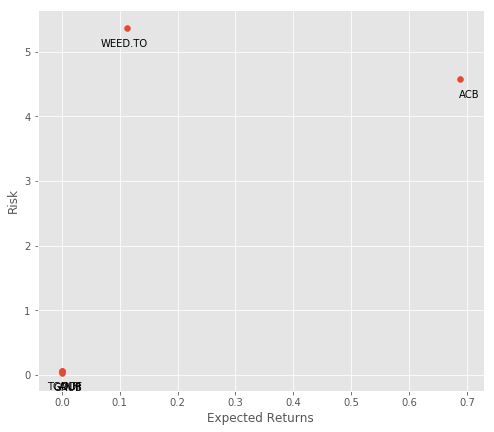

In [0]:
#extracting the average of returns and standard deviation of risk for each stock
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected Returns')
plt.ylabel('Risk')
for label, x, y, in zip(retscomp.columns, retscomp.mean(),
retscomp.std()): #CORRECTION: separated onto different lines for easier readability, moved xytext after textcoords definition
    plt.annotate(
        label, #this is the text
        xy = (x, y), #this is the point to label
        textcoords='offset points',#how to position the text. 
        xytext = (20, -20), #used to say test, changed to text. distance from text to points x,y
        ha='right', #horizontal alignment can be left right or center
        va='bottom') #vertical alignment can be top middle or bottom
        #bbox = dict(boxstyle = 'round4,pad=0.5', fc = 'yellow', alpha = 0.5),
        #arrowprops = dict(arrowstyle = '->',, connectionstyle = 'arc3, rad=0'))



In [0]:
#Engineering some features for the algorithms: High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

##PREPROCESSING AND DATA VALIDATION
#Drop missing value
dfreg.fillna(value=-99999, inplace = True)
dfreg.dropna(inplace=True) #CORRECTION: ADDED NEW SO X AND y ARE EQUAL

#we want to separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg))) #CORRECTION: was called incorrectly in former code below
#FORMERCODE forecast_out = int(math.ceil(0.01 * len(dfreg)))





In [0]:
#separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [0]:
#Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

##TIME TO START THE CLASSIFIERS!

#CORRECTION: DEFINING X_train before we use it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [0]:
#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
('The linear regression confidence is', confidencereg)
('The quadratic regression 2 confidence is ', confidencepoly2)
('The quadratic regression 3 confidence is ', confidencepoly3)
('The knn regression confidence is ', confidenceknn)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly2 = clfpoly2.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly3 = clfpoly3.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_knn = clfknn.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
dfreg['Forecast'] = np.nan


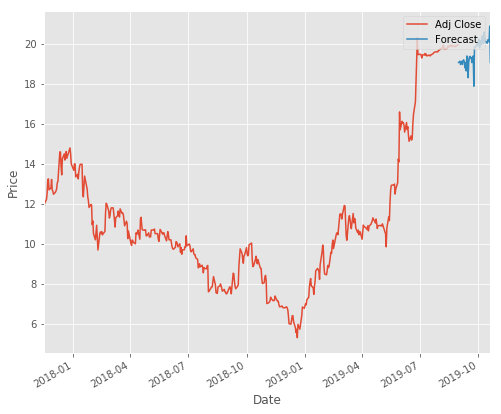

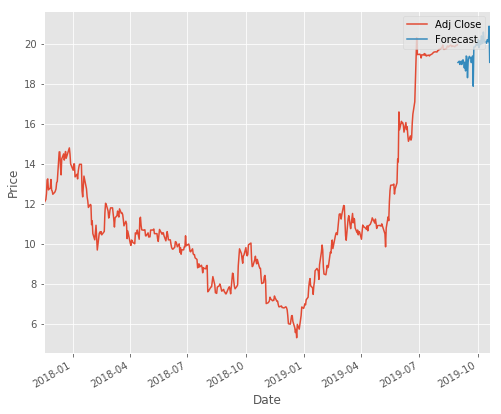

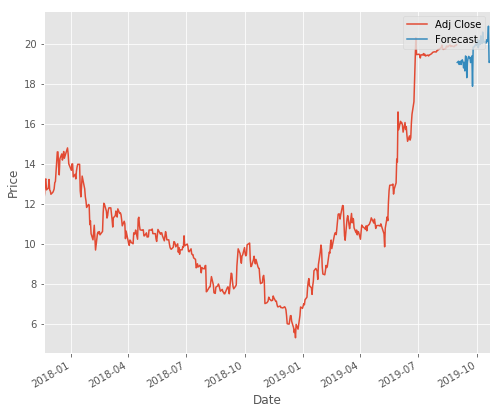

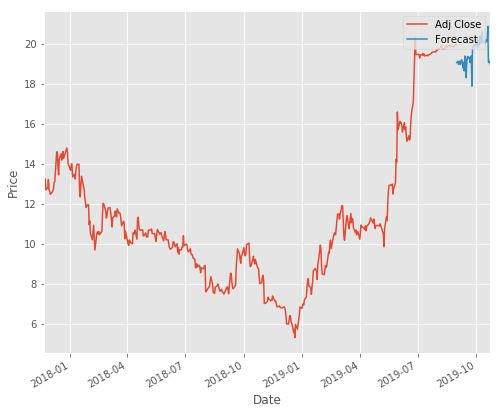

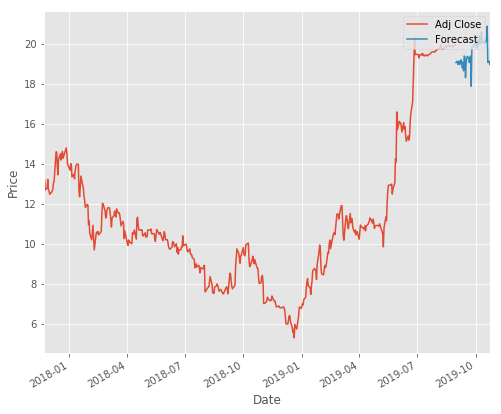

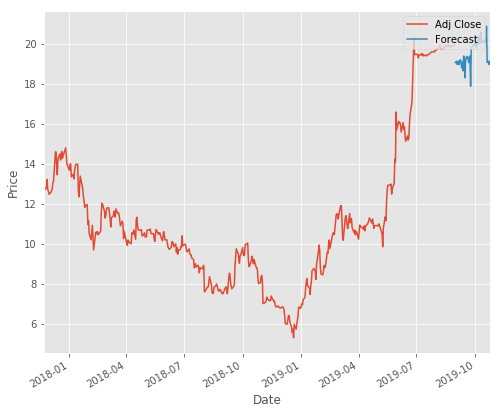

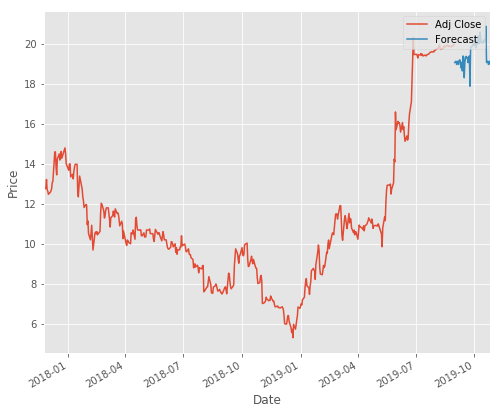

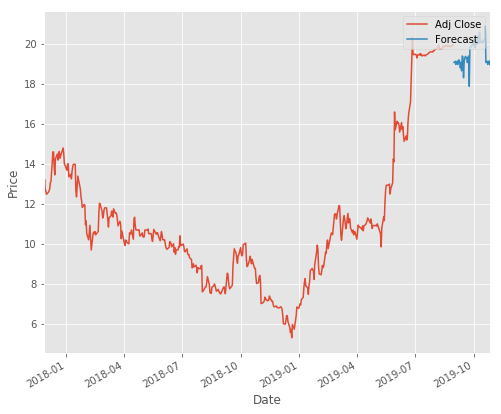

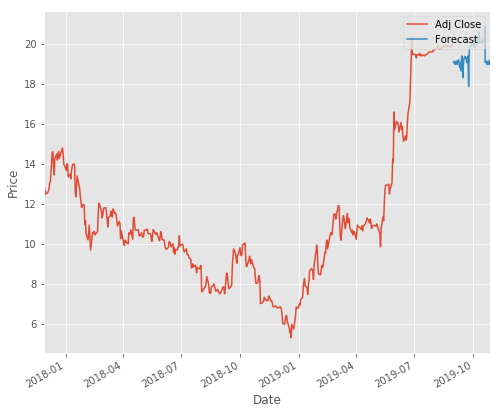

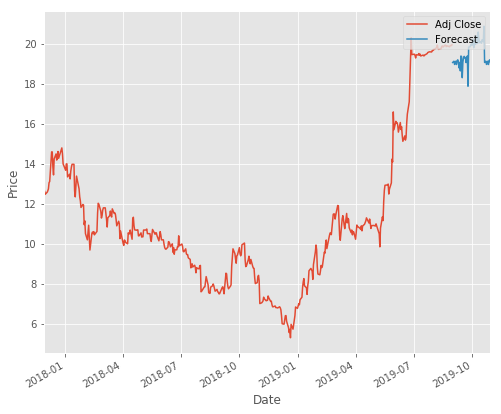

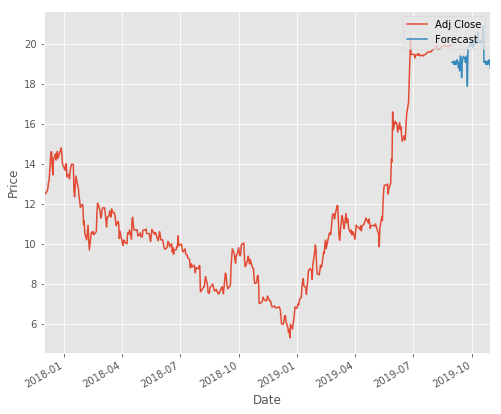

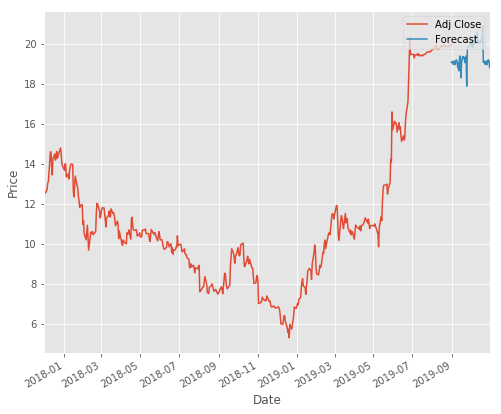

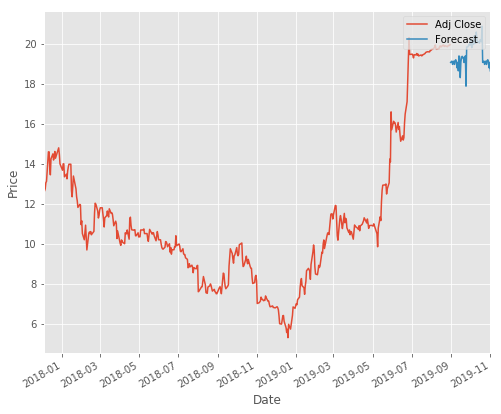

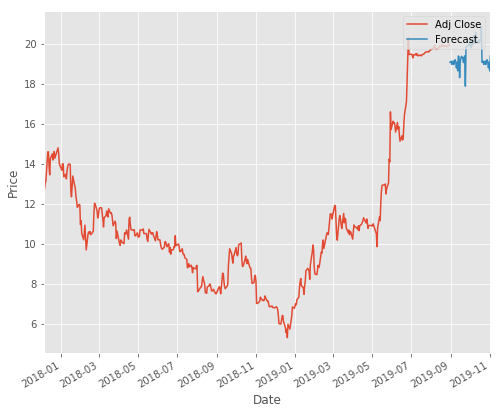

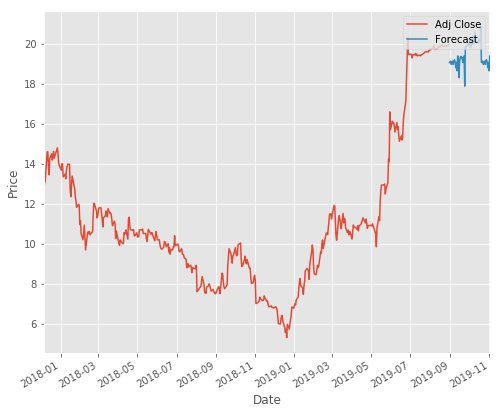

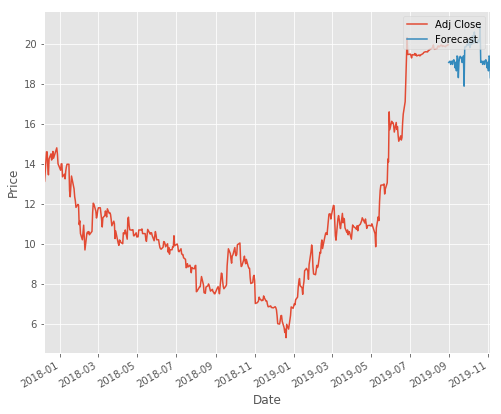

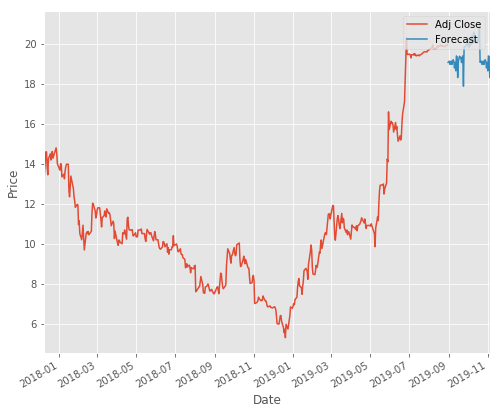

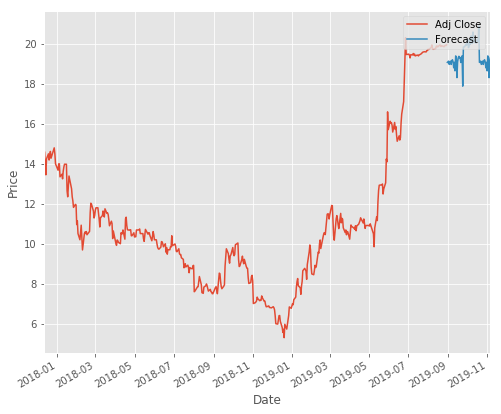

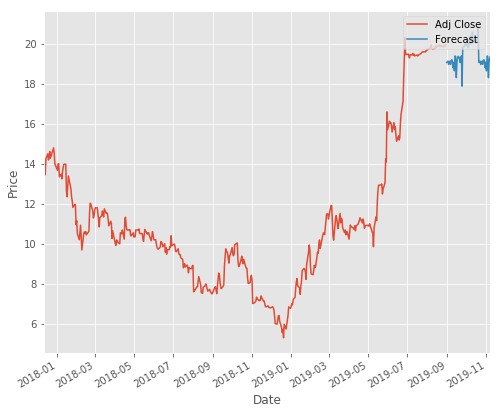

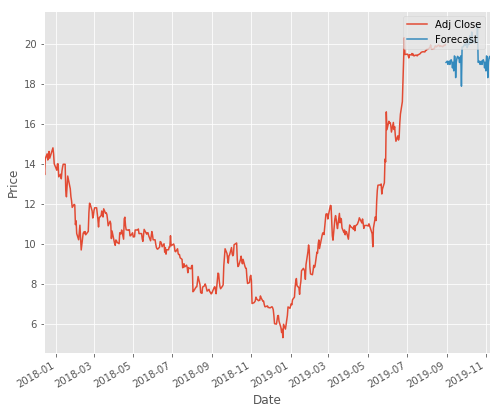

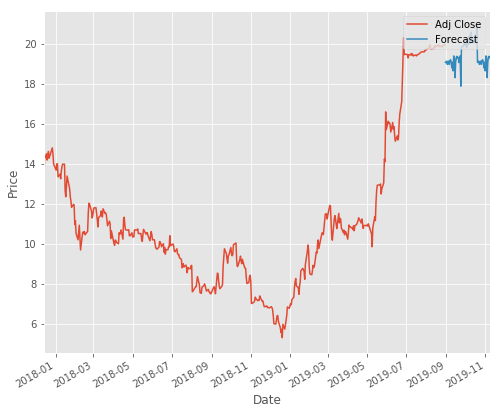

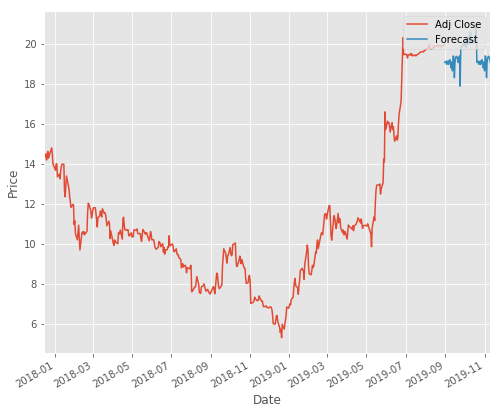

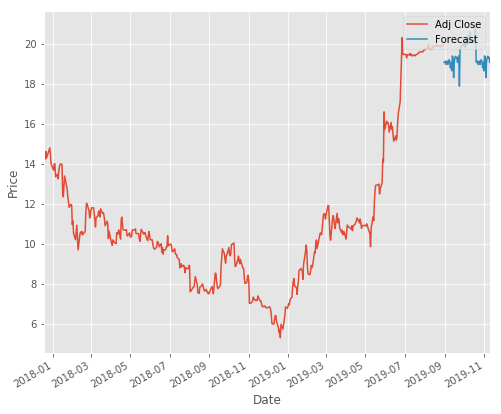

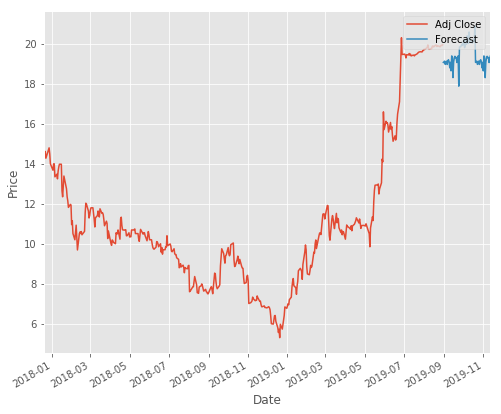

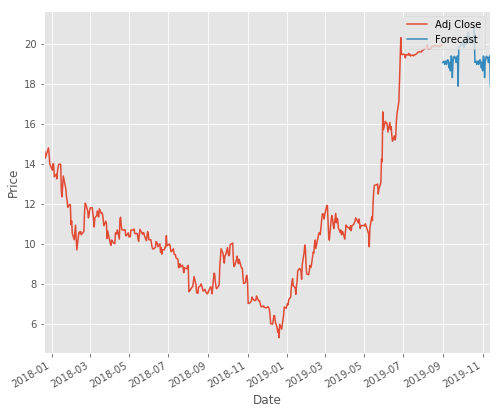

In [0]:
#results

#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

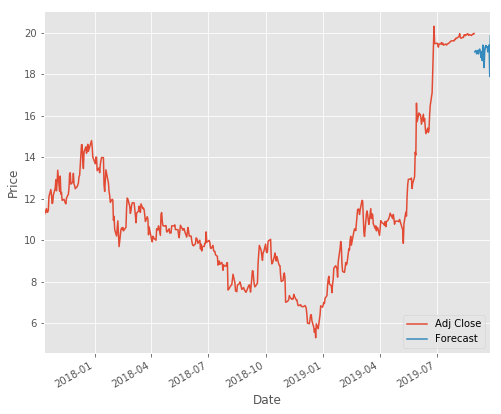

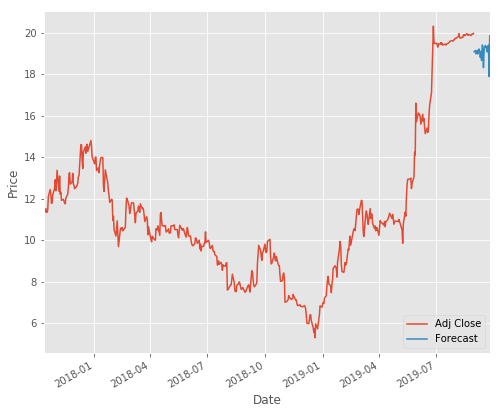

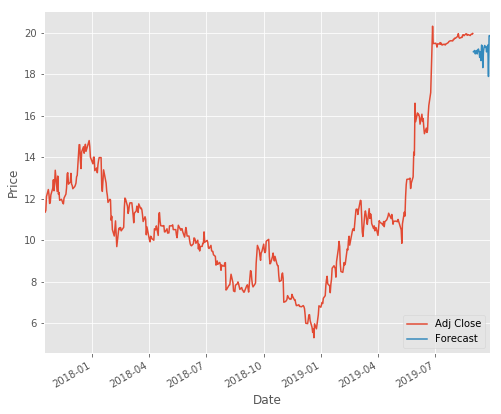

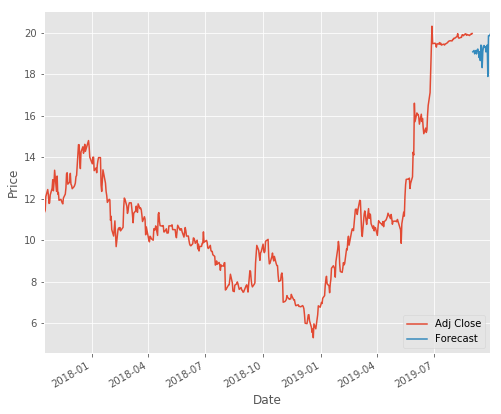

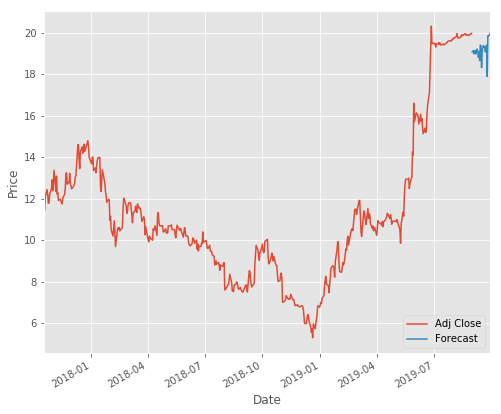

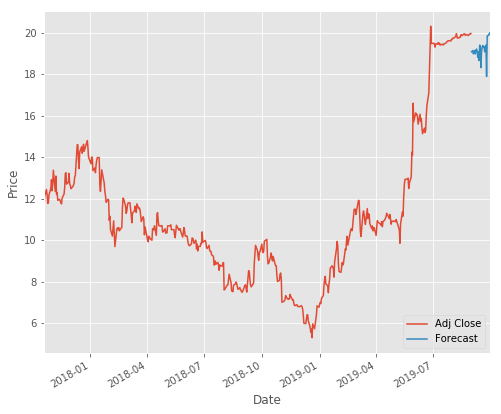

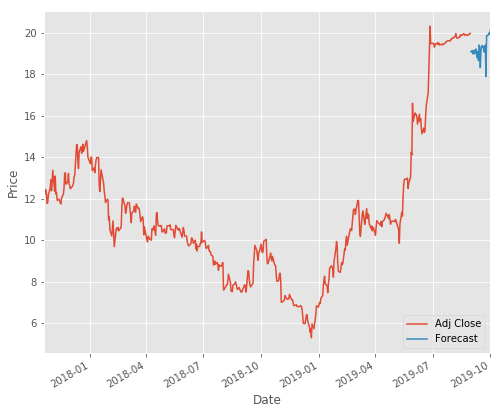

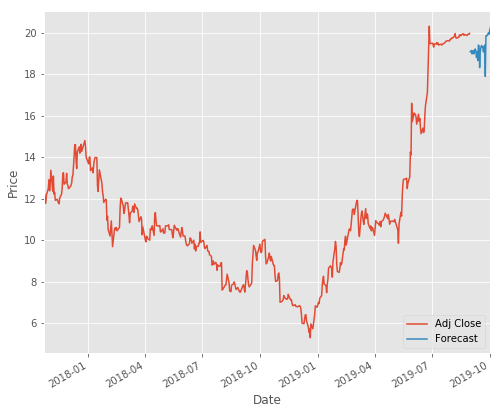

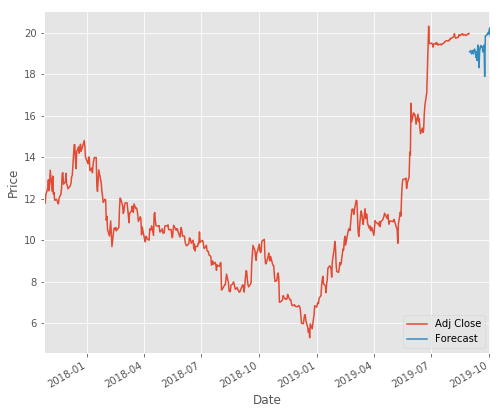

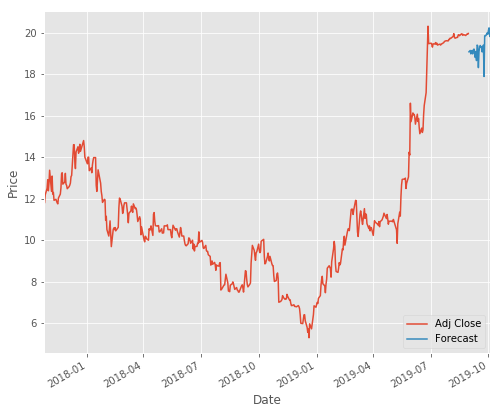

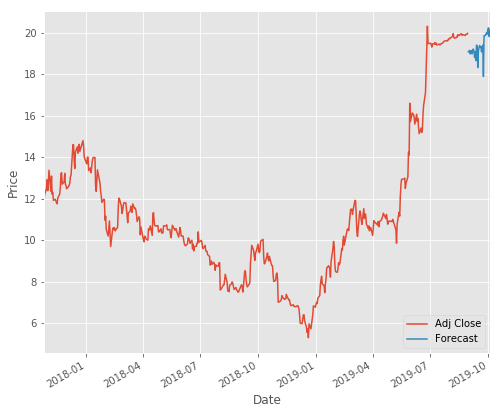

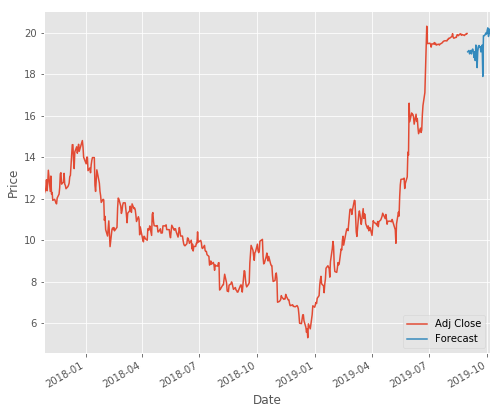

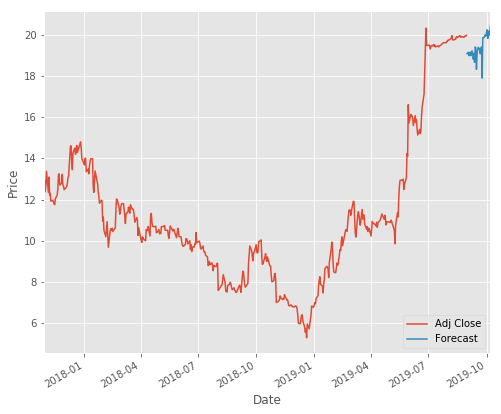

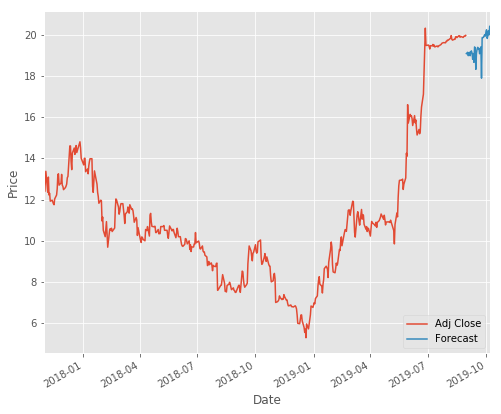

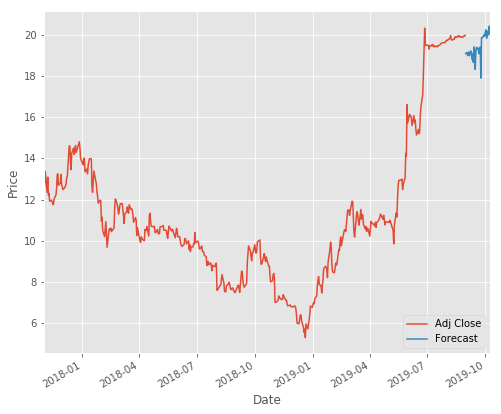

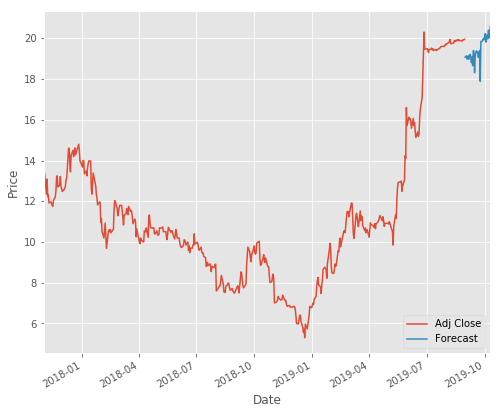

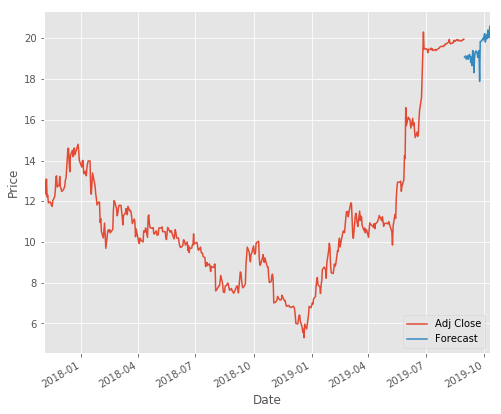

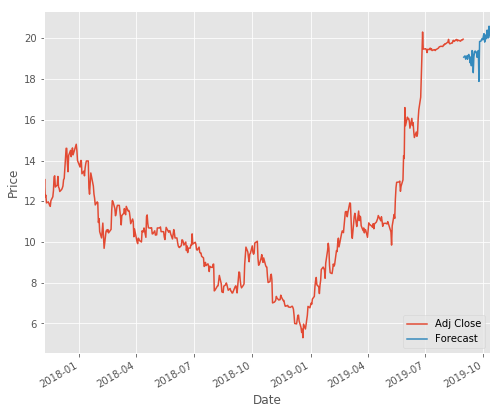

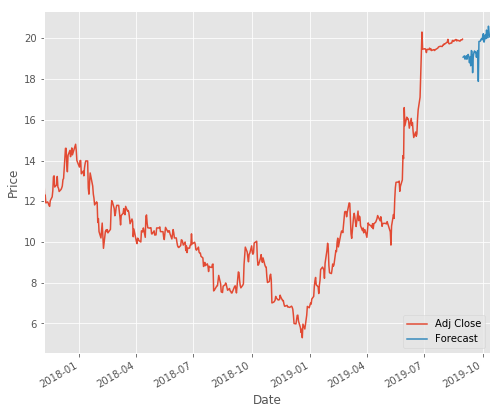

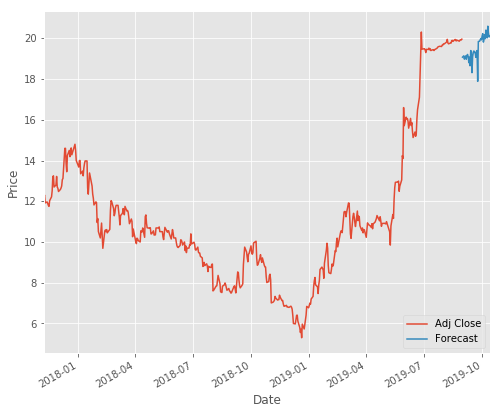

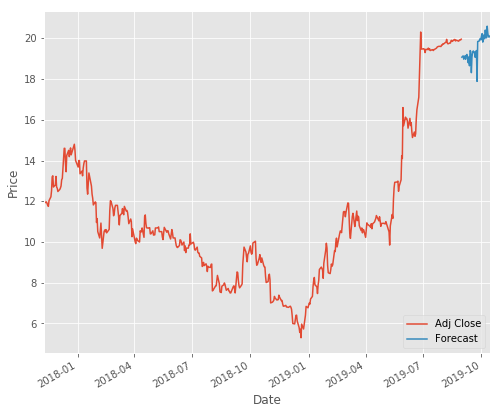

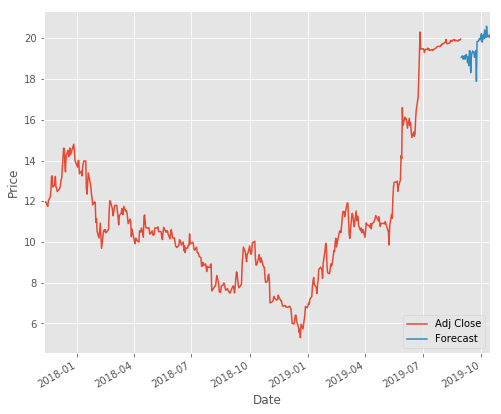

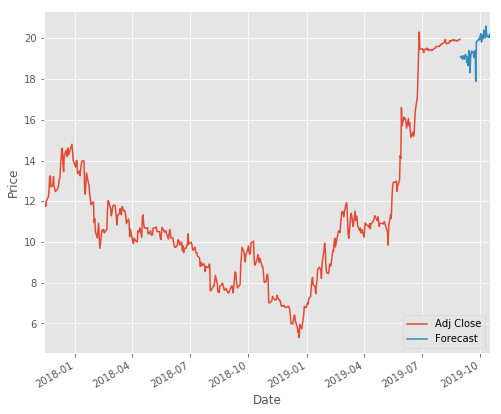

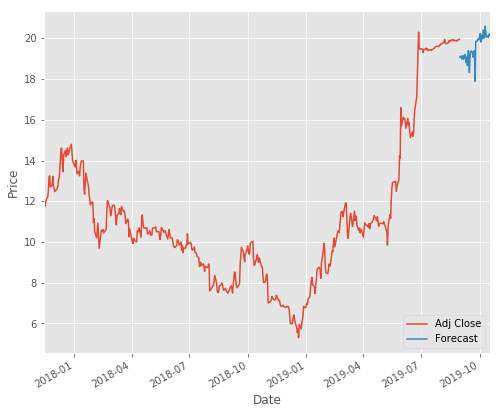

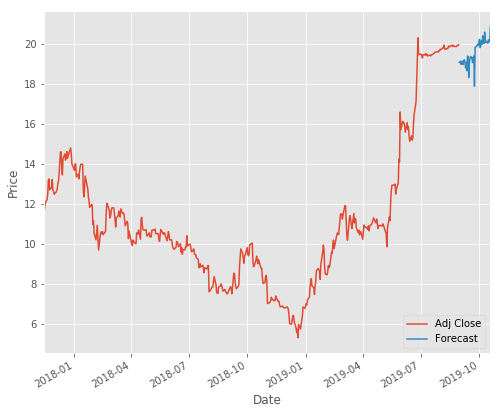

In [0]:
for i in forecast_set_poly2: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

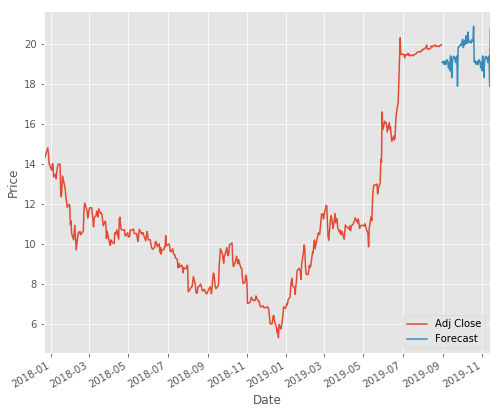

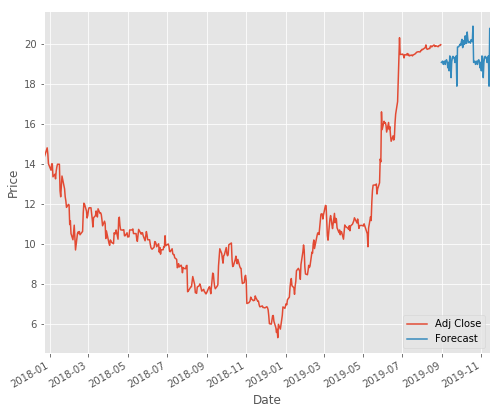

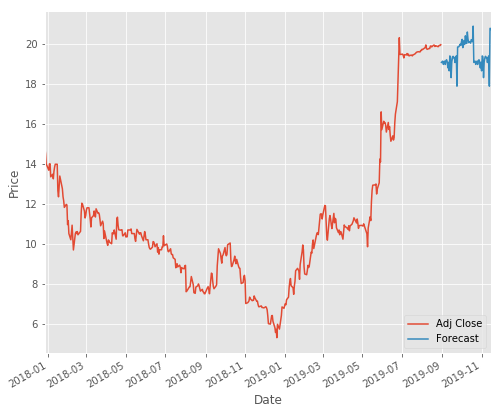

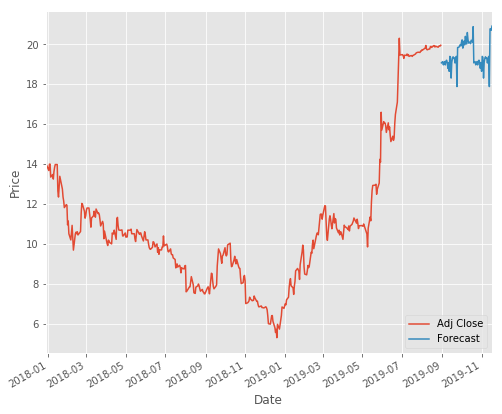

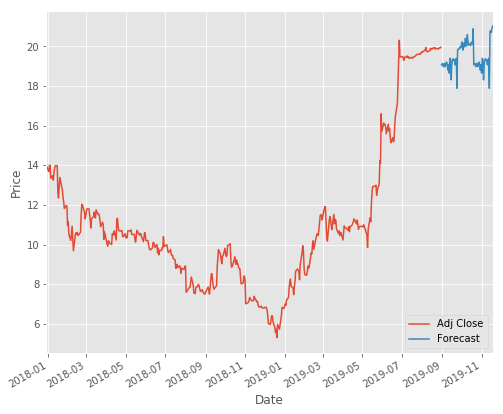

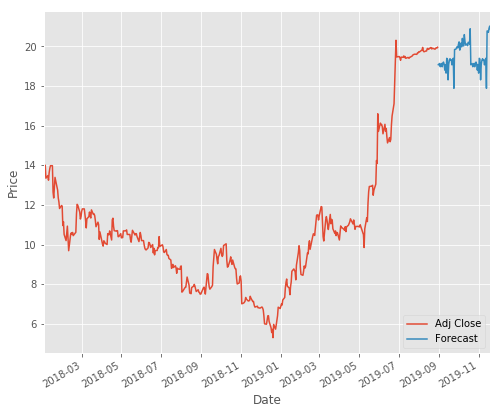

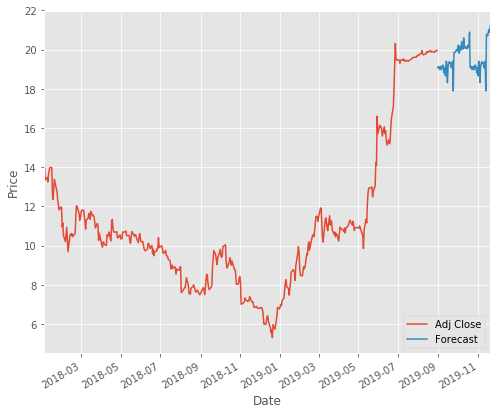

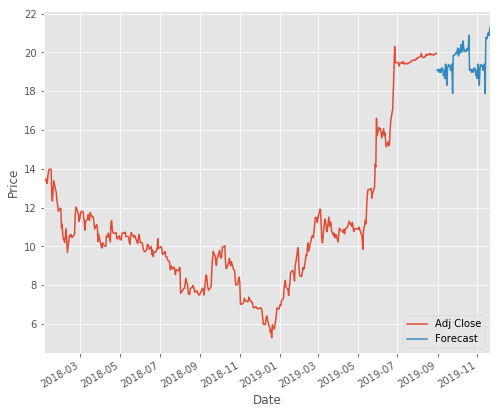

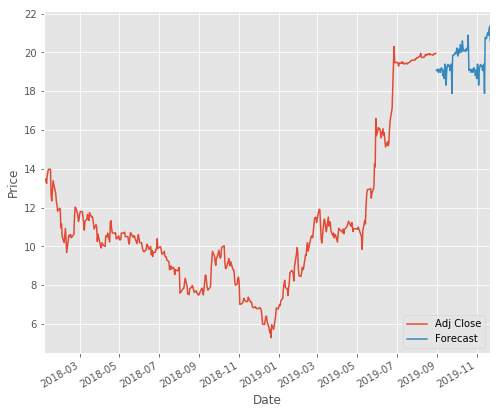

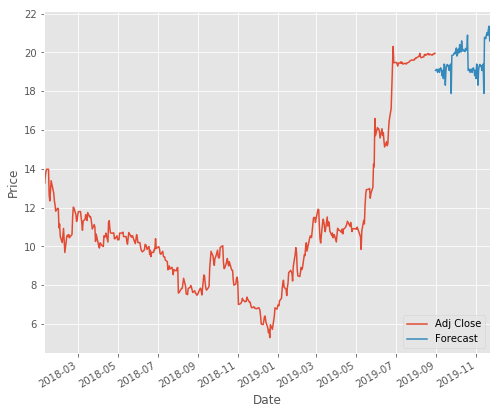

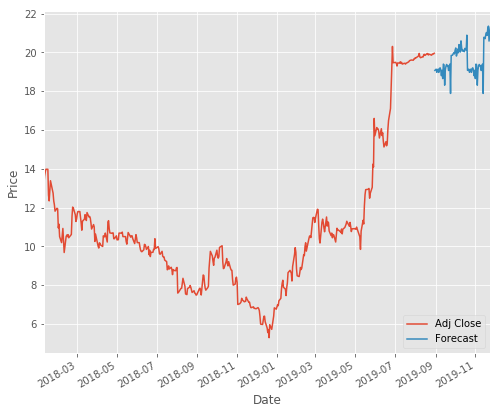

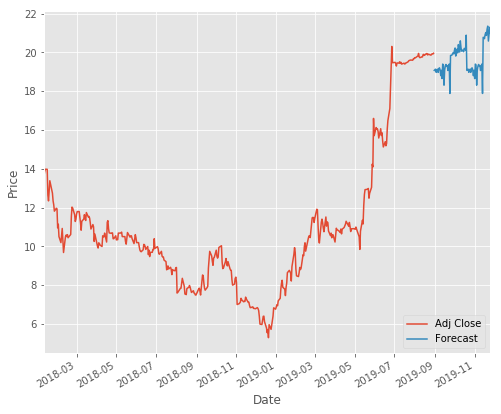

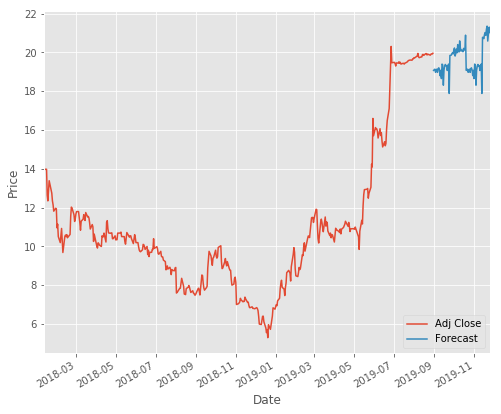

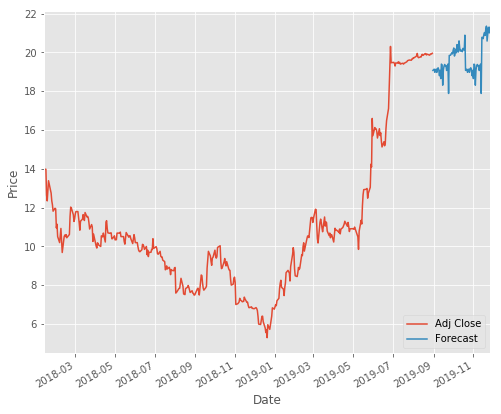

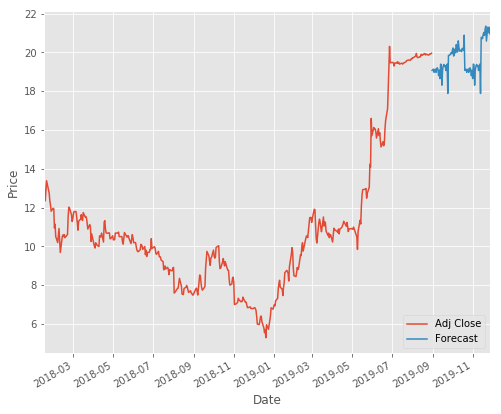

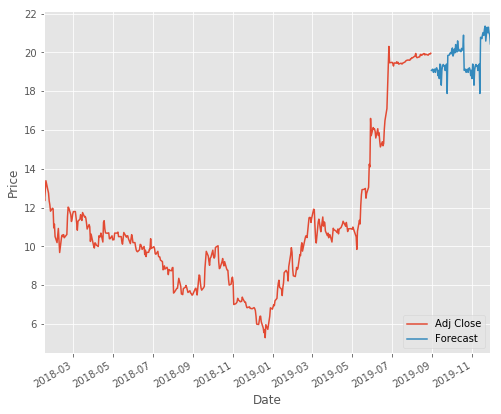

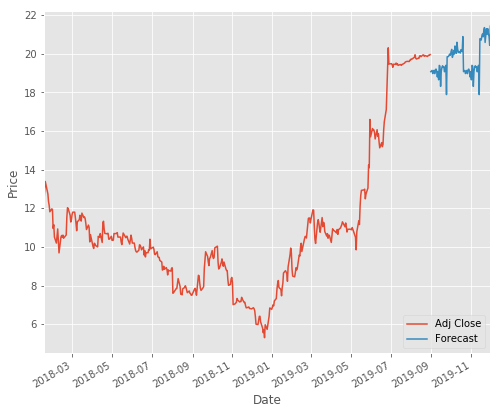

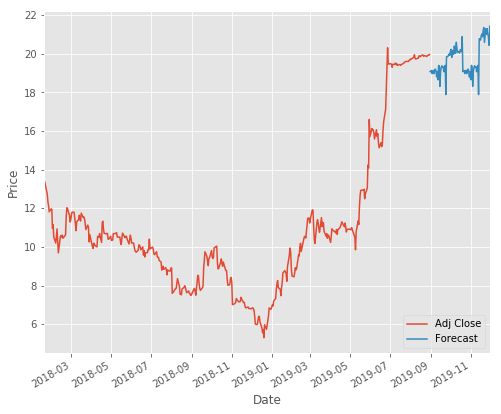

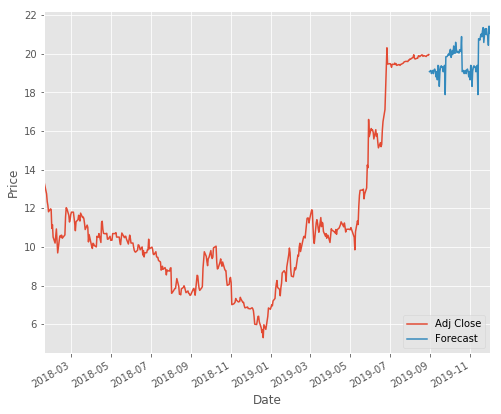

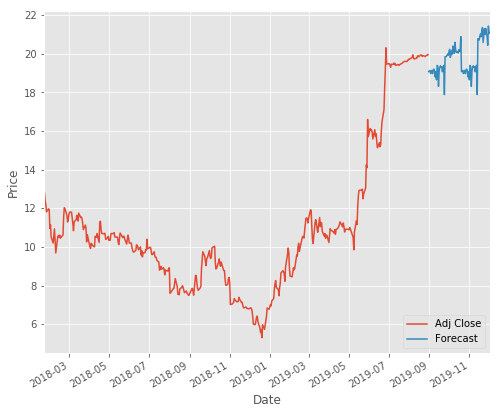

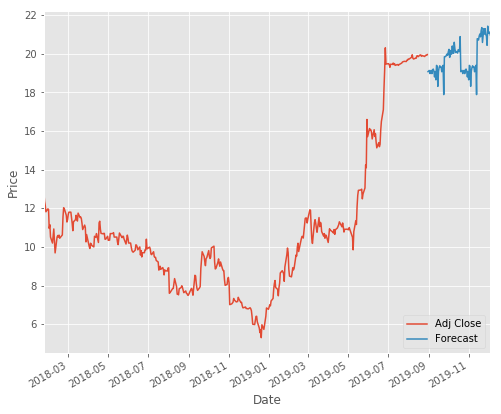

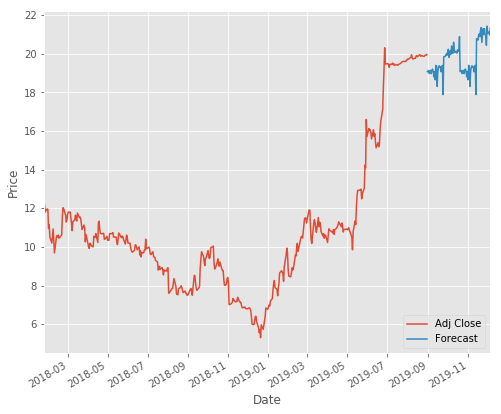

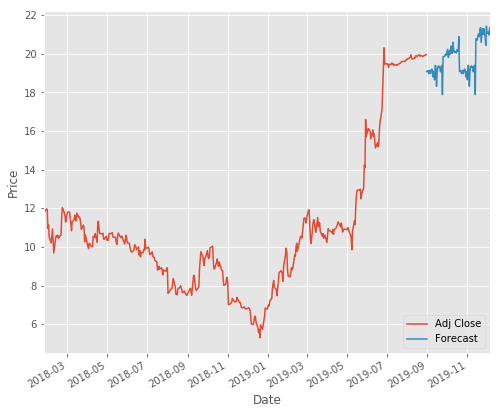

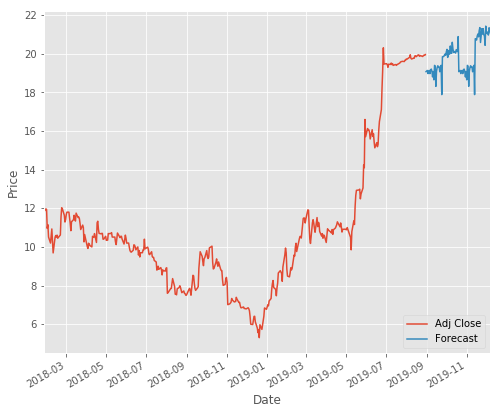

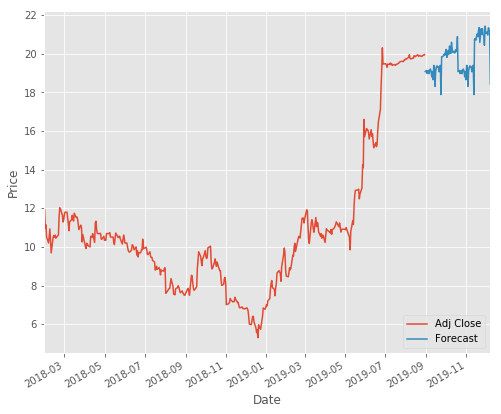

In [0]:
for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

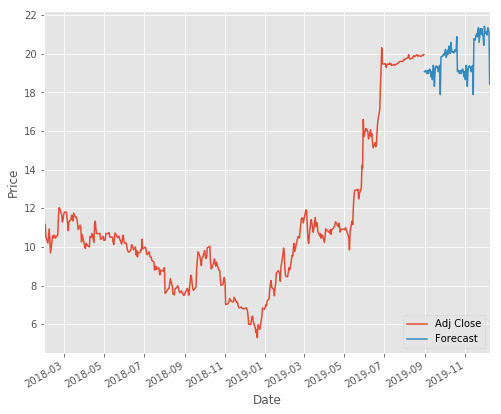

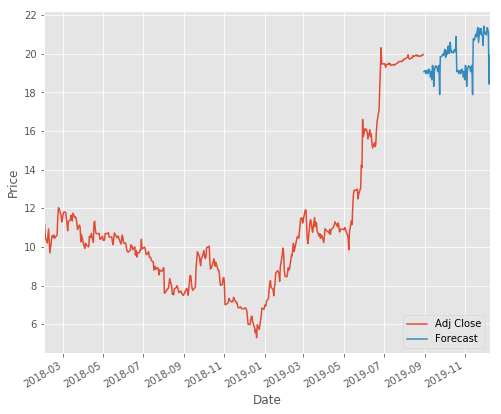

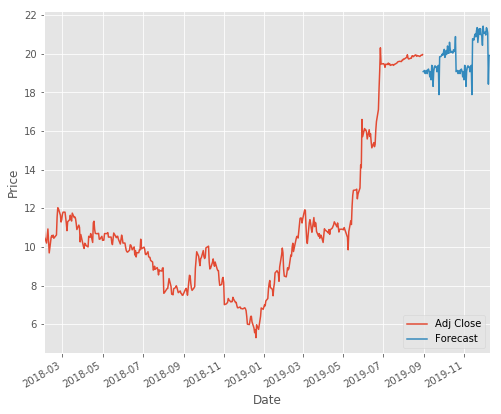

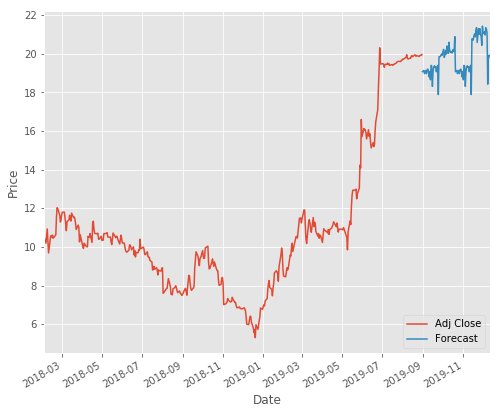

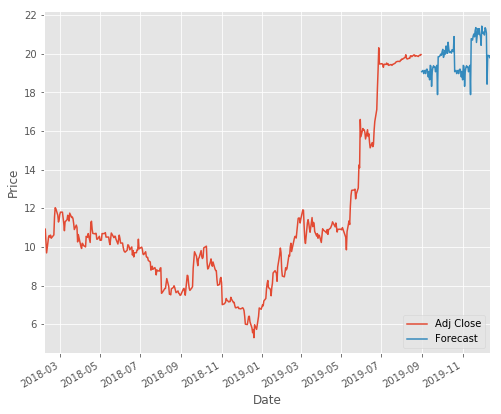

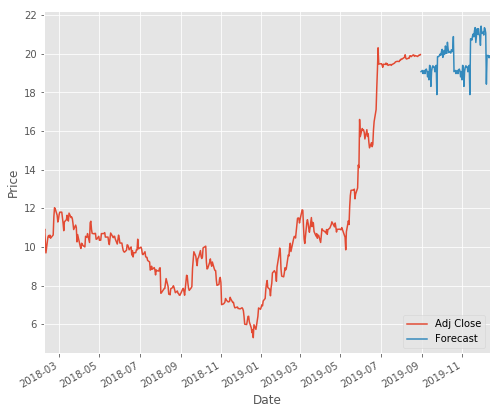

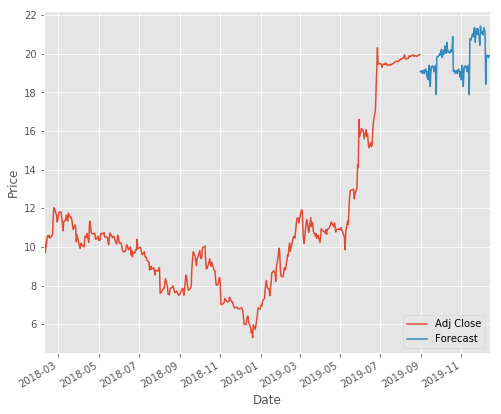

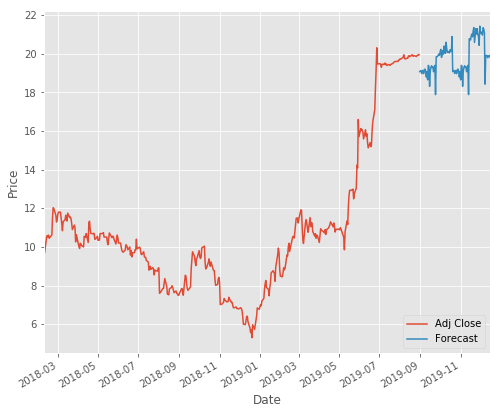

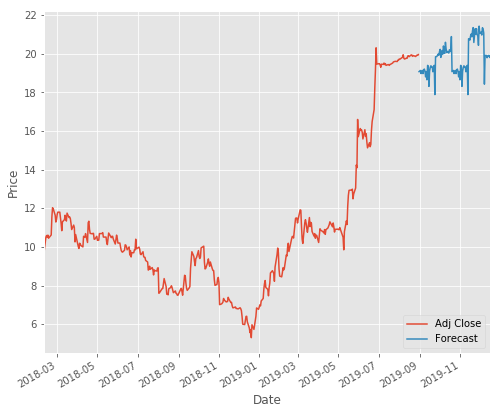

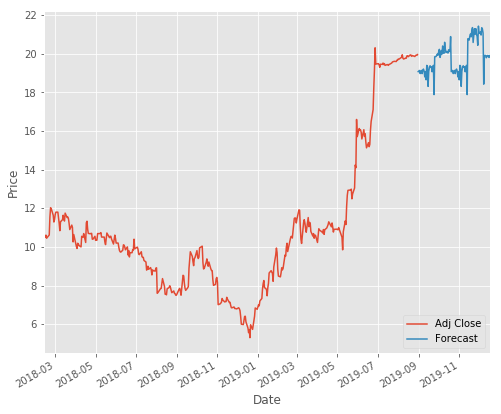

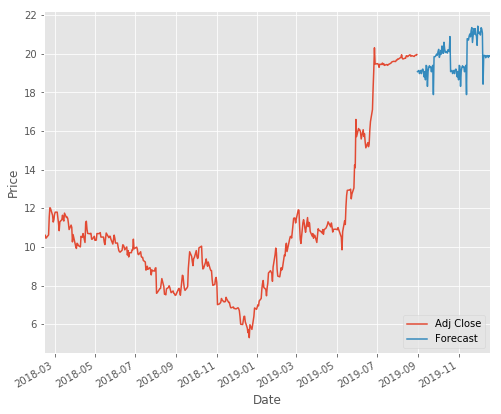

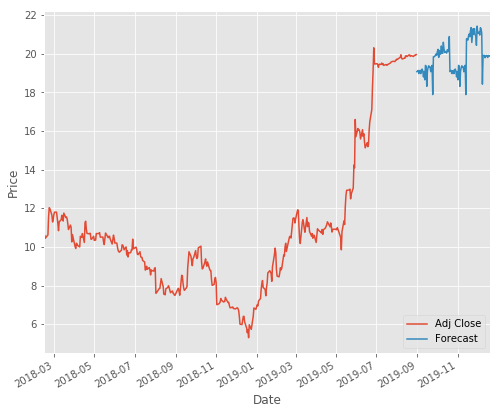

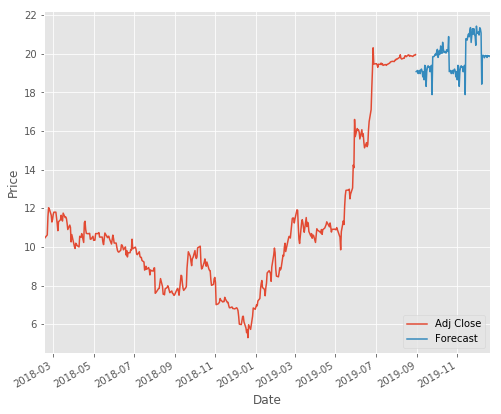

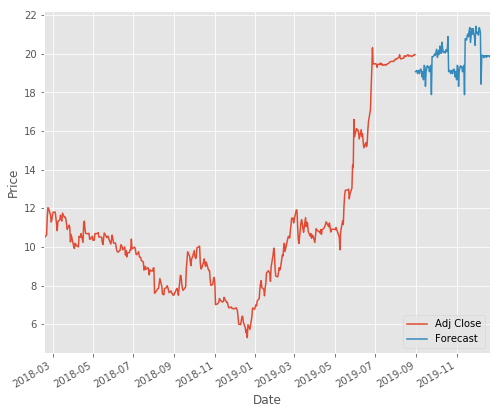

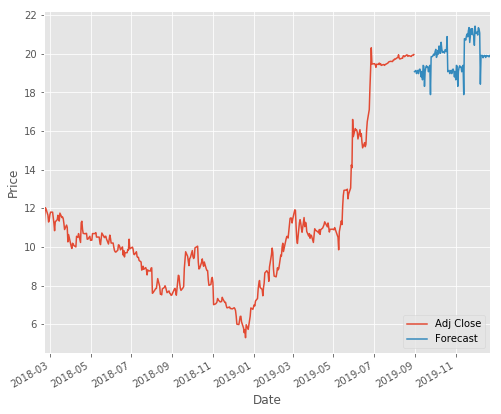

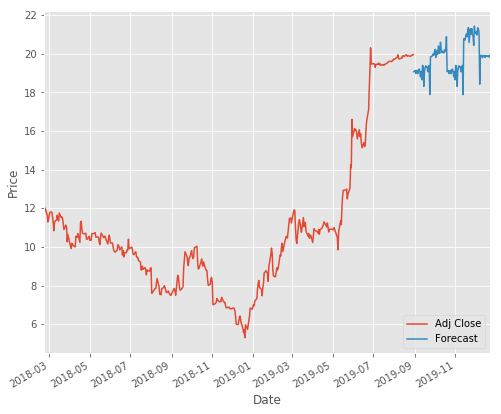

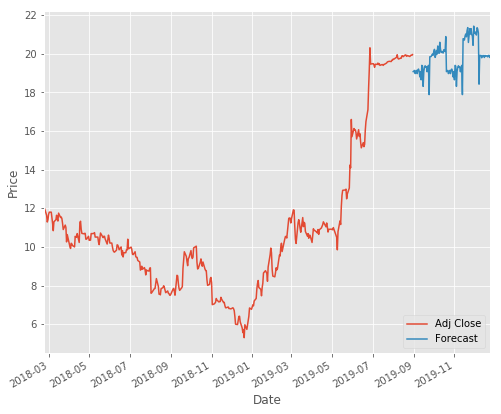

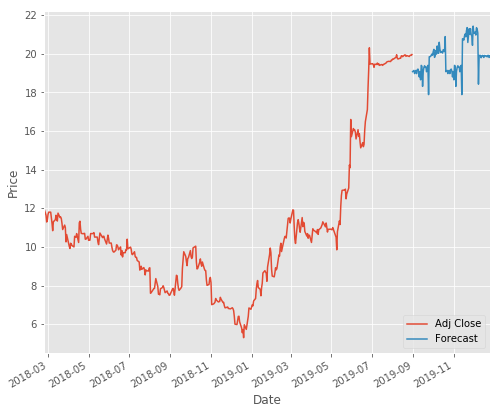

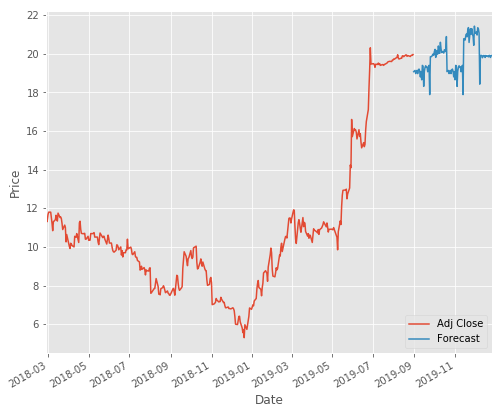

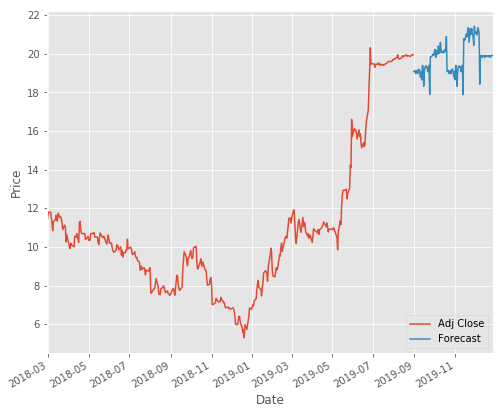

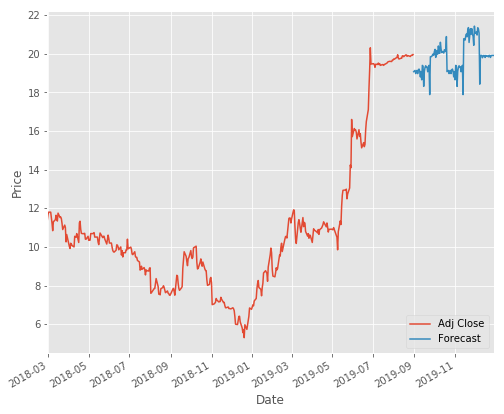

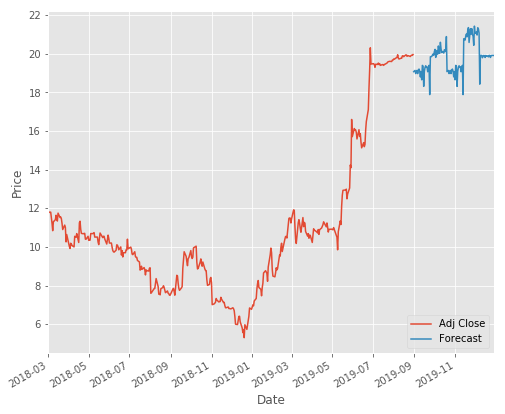

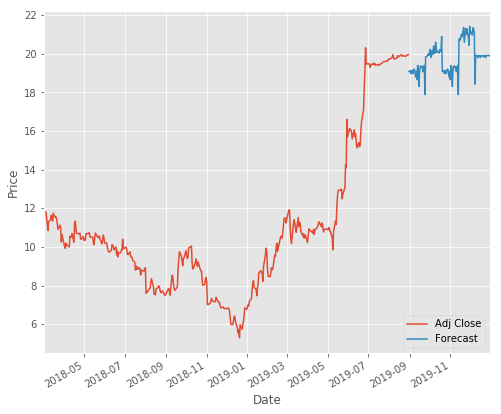

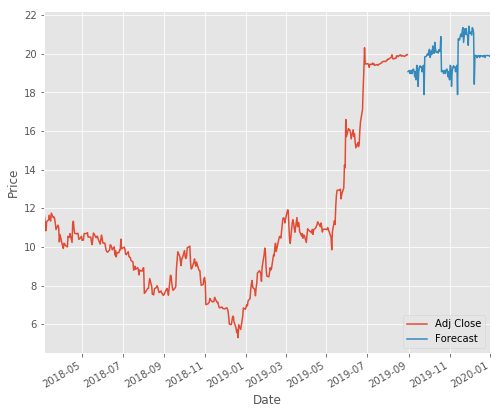

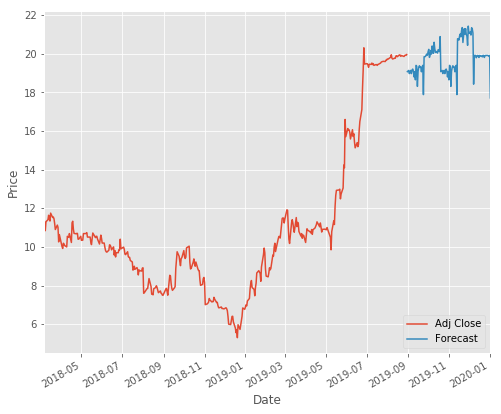

In [0]:
for i in forecast_set_knn: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()